# 教科書3.4と3.5『ガウス過程回帰モデル』の実装

ガウス過程回帰をみんなで理解しましょう．

## jupyterhubで動かす準備

jupyterhubを開く．

新規を押す．

端末を開く．

```
$ git clone https://github.com/LABO-M/Gaussian_process.git
```

を入力してEnterを押す．

ディレクトリが入っているか確認．


# 下準備

今回必要になるライブラリのインポートします．

必要に応じて再度インポートしますのでご安心ください．

In [1023]:
# coding: utf-8
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import os
import sklearn 
from sklearn.model_selection import train_test_split

matplotlib.style.use('ggplot')

現在のディレクトリを一応確認しましょう．今後の助けになるかもしれません．

In [1024]:
path = os.getcwd() # 現在のカレントディレクトリを確認
print(path)

/home/taichi/ドキュメント/code/Gaussian_process


## データの生成
今回用いるデータの生成をしましょう．

生成するのはランダムウォークです．

理論をはじめに説明します．

以下の規則で$z_t$を生成します．

$$
z_t = 
\left\{ \,
    \begin{aligned}
    & 1 \\
    & 0 \\
    & -1
    \end{aligned}
\right.
$$

すべて当確率，つまり$1/3$で発生します．

そして，ブラウン運動にするために各$t$の値を時刻$T$まで加算した$W_T$を以下のように定義します．

$$
W_T = \sum^{T}_{t=1} z_t
$$

In [1025]:
np.random.seed(121)
#時間データの生成
times = pd.date_range(start="2010-04" , end = "2020-04")
#時系列データを作成（ランダムウォーク）
time_len = len(times)
random = np.random.randint(-1 , 2 , time_len)

def data(random , times): # 時間データと乱数を引数に
    datas = np.zeros(time_len)
    for j in range(time_len):
        if j == 0:
            datas[j] = random[j]
        else :
            datas[j] = datas[j-1] + random[j]
    return datas

%time data = data(random , times)

CPU times: user 1.1 ms, sys: 37 µs, total: 1.14 ms
Wall time: 1.14 ms


実際に作成したデータフレームを見てみましょう．

時系列データをイメージできるように日時を追加しました．

In [1026]:
df = pd.DataFrame(data , index = times,columns = ["random_walk"])
df.head()

,random_walk
2010-04-01,1.0
2010-04-02,1.0
2010-04-03,0.0
2010-04-04,-1.0
2010-04-05,-1.0


In [1027]:
df["random_walk"]

2010-04-01    1.0
2010-04-02    1.0
2010-04-03    0.0
2010-04-04   -1.0
2010-04-05   -1.0
             ... 
2020-03-28   -4.0
2020-03-29   -3.0
2020-03-30   -2.0
2020-03-31   -3.0
2020-04-01   -4.0
Freq: D, Name: random_walk, Length: 3654, dtype: float64

In [1028]:
random

array([ 1,  0, -1, ...,  1, -1, -1])

グラフを作成して可視化しましょう．

Text(0.5, 1.0, 'random_walk_1dim')

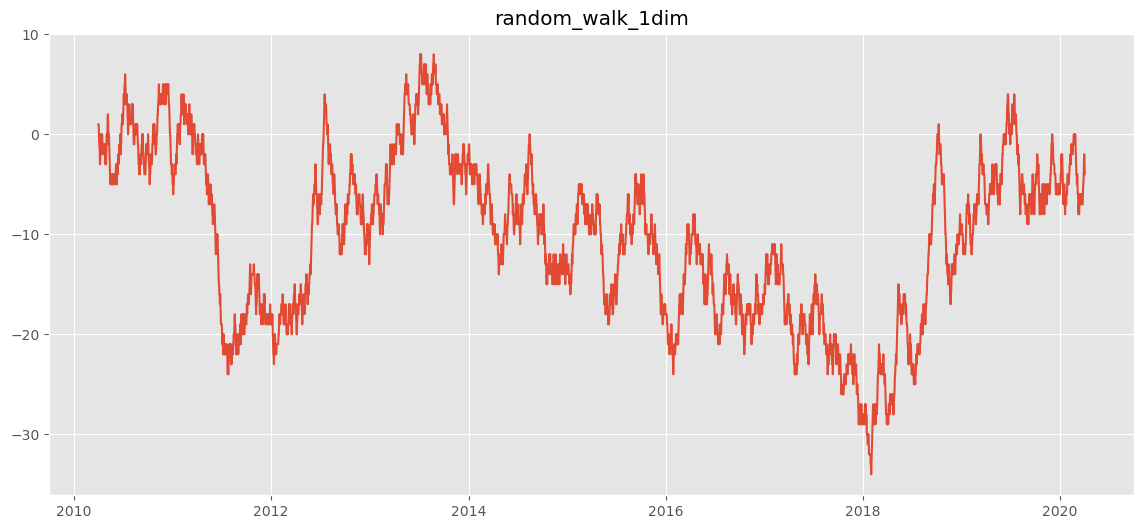

In [1029]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(14, 6))

Y = df["random_walk"]
ax.plot(Y)
ax.set_title("random_walk_1dim")

ブラウン運動っぽいですね！

ここでもう少しデータを理解するために，期待値と分散共分散行列の理論計算をしてみましょう．

### 期待値
$z_t$の期待値を計算しましょう．

$$
\braket{z_t} = 1 × \frac{1}{3} + 0 × \frac{1}{3} + (-1) × \frac{1}{3}  = 0
$$

よって
$$
\braket{W_T} = \braket{\sum^{T}_{t = 1} z_t} = \sum^{T}_{t = 1} \braket{z_t} = 0
$$

が得られます．

### 分散
$z_t$の分散を計算しましょう．

$$
\braket{z_t^2} = 1^2 × \frac{1}{3} + 0^2 × \frac{1}{3} + (-1)^2 × \frac{1}{3}  = \frac{2}{3}
$$

よって
$$
\braket{W_T^2} = \braket{(z_1 + z_2 + ・・・ + z_T)^2} = \sum^{T}_{t = 1} \braket{z_t^2} + \sum_{i  \neq j} \braket{z_i}\braket{z_j}= \frac{2}{3} T
$$

### 共分散
$t \neq \tau$として$W_t$と$z_\tau$の共分散を求めましょう．

$$
\braket{W_t ・ W_\tau} = \braket{(z_1 + z_2 + ・・・ + z_t)(_1 + z_2 + ・・・ + z_\tau)} = \frac{2}{3} \min{(t ,\tau)}
$$

ガウス過程回帰のモデル化をするためには，これらの値がわかっていることがとても重要です．

また，生データでは例えばスペクトルを計算してみたり，標本分散共分散行列を可視化してみたりして，データの前処理をした上でモデル化を試みることが有効です．

これらの事は今回の趣旨には反しますが，実際に実装する場合のためには時系列解析の基本的なことを知っておくことが有効です．

https://di-acc2.com/analytics/statistics/12946/

実装に戻りましょう．

データ数が大きいのでデータを月ごとに平均化しデータ数を落とします．

In [1030]:
Dataset = df.groupby(pd.Grouper(freq='M')).mean() # freq='M'は月ごと

In [1031]:
Dataset.head()

,random_walk
2010-04-30,-1.200000
2010-05-31,-2.677419
2010-06-30,-1.966667
2010-07-31,2.645161
2010-08-31,0.096774


Text(0.5, 1.0, 'Train')

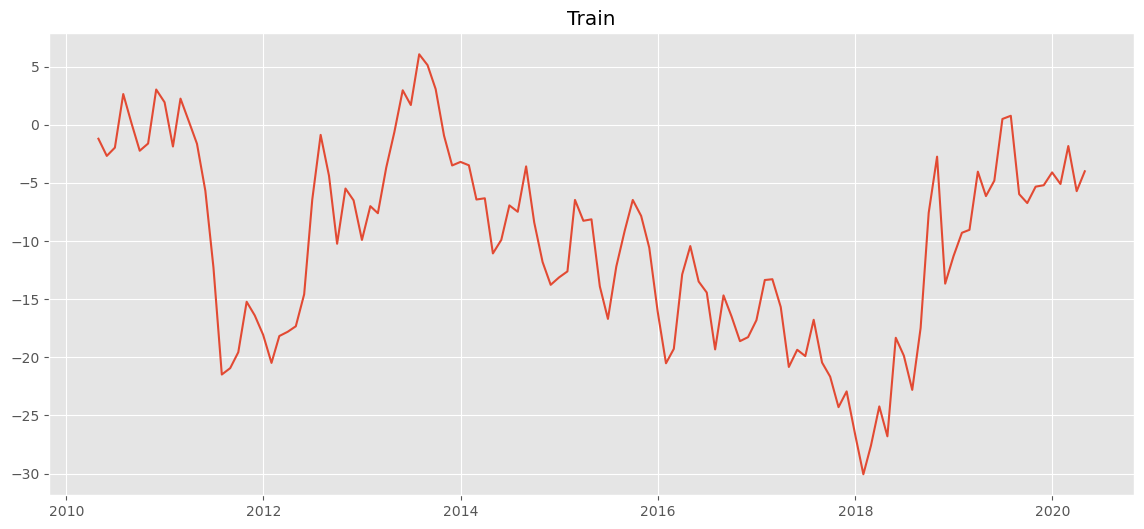

In [1032]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(14, 6))

Y = Dataset["random_walk"]
ax.plot(Y)
ax.set_title("Train")

まだブラウン運動っぽいですね！

説明変数が時間になっているので，自然数でナンバリングします．

In [1033]:
x = pd.DataFrame(np.arange(0 , len(Dataset)),index=Dataset.index ,columns = ["x"])
x.head()

,x
2010-04-30,0
2010-05-31,1
2010-06-30,2
2010-07-31,3
2010-08-31,4


In [1034]:
Dataset0 = pd.concat([x , Dataset] , axis =1 )
Dataset0.head()

,x,random_walk
2010-04-30,0,-1.200000
2010-05-31,1,-2.677419
2010-06-30,2,-1.966667
2010-07-31,3,2.645161
2010-08-31,4,0.096774


これでデータセットを作ることができました．

## 学習のためにデータを分割

機械学習は訓練データ，交差検証データ，テストデータに分けてそれぞれの誤差を小さくするために頑張るものであることをすでに学びました．

さっそく，データを訓練データと交差検証データ，テストデータの3つに分けます．

In [1035]:
X , y = Dataset0["x"] , Dataset0["random_walk"]

In [1036]:
# データの分割
def data_split(X,y):
    X_train , X_cross , y_train, y_cross = train_test_split(X , y ,random_state=123 , test_size=0.5)
    X_cross , X_test , y_cross, y_test = train_test_split(X_cross , y_cross ,random_state=123 , test_size=0.4)
    return X_train , X_cross , X_test , y_train , y_cross , y_test

In [1037]:
X_train , X_cross , X_test , y_train , y_cross , y_test = data_split(X,y)

学習データ：50%

交差検証データ：30%

テストデータ：20%

として分割しました．

In [1038]:
print(len(X))
print("----------------")
print(len(X_train))
print(len(y_train))
print(len(X_cross))
print(len(y_cross))
print(len(X_test))
print(len(y_test))

121
----------------
60
60
36
36
25
25


使いやすいようにデータフレームを作り直します．

分割する際にシャッフルされてしまうので，ソート文で治すコードがありますがそういうことです．

訓練データセットはD_train

交差検証データセットはD_cross

テストデータセットはD_test

In [1039]:
# データを扱いやすいように定義
def data_def(X,y):
    D_x = pd.DataFrame(X ,index = X.index , columns = ["x"])
    D_y = pd.DataFrame(y ,index = y.index , columns = ["random_walk"])
    D0 = pd.concat([D_x , D_y] , axis =1 ) 
    D = D0.sort_values(by = "x")
    return D

def cross_def(X,y):
    D_x = pd.DataFrame(X ,index = X.index , columns = ["x"])
    D_y = pd.DataFrame(y ,index = y.index , columns = ["random_walk"])
    D = pd.concat([D_x , D_y] , axis =1 ) 
    return D

In [1040]:
D_train =  data_def(X_train , y_train)
D_cross =  cross_def(X_cross , y_cross)
D_test =  data_def(X_test , y_test)

各データを色付けして見てみましょう！

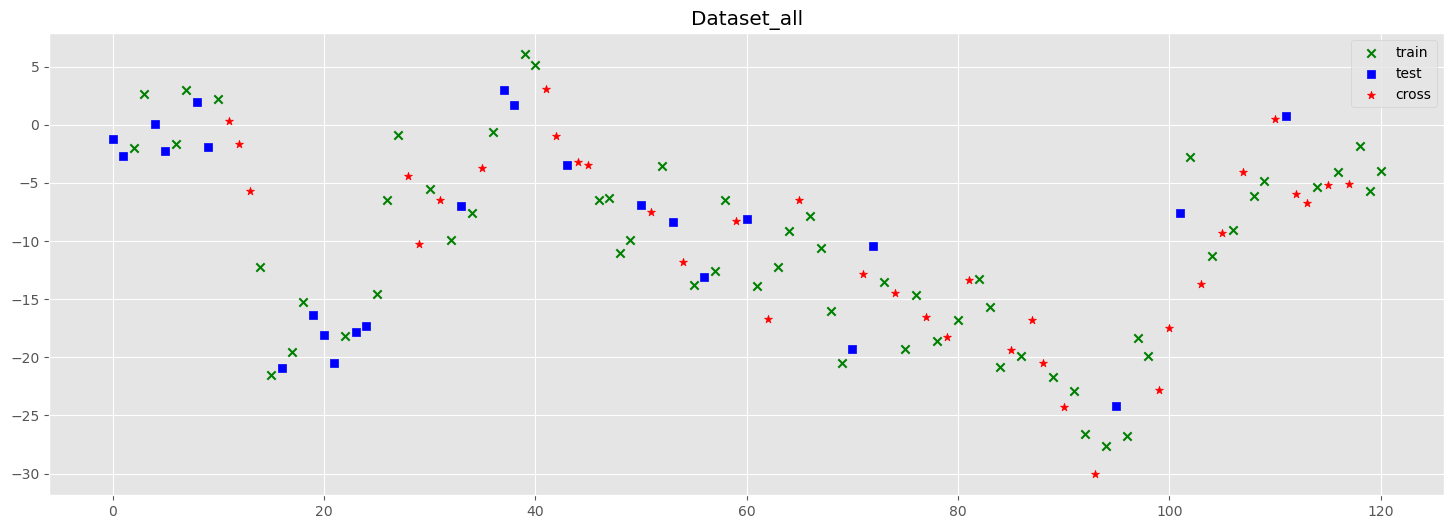

In [1041]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

train_x = D_train["x"]
train_y = D_train["random_walk"]
cross_x = D_cross["x"]
cross_y = D_cross["random_walk"]
test_x = D_test["x"]
test_y = D_test["random_walk"]
ax.scatter(train_x , train_y,marker='x' , label = 'train',color='green')
ax.scatter(test_x , test_y,marker='s' ,label = 'test',color='blue')
ax.scatter(cross_x , cross_y ,marker = '*' , label = 'cross' ,color='red')
ax.set_title("Dataset_all")

ax.legend()
plt.show()

訓練データで使うのは緑

交差検証データで使うのは赤

テストデータで使うのは青

と色付けしてみました．


## 動径基底関数回帰

基底関数を動径基底関数
$$
\phi_h (x) = \exp{\{-\frac{(x-\mu_h)^2}{\sigma^2}\}}\ , \ (h = -H , \frac{1}{H} - H , ... , - \frac{1}{H}+H , H)
$$

としたときの回帰問題をサンプルとして提示します．

### モデル化

データセット$\mathcal{D} = \{ (x_n , y_n ) \} _{n = 1,...,N_{train}}$が与えられています．

このデータ間の回帰を以下のような回帰関数でモデル化します．

$\vec{\phi}(x) = (\phi_{-H}(x) , \phi_{\frac{1}{H} - H}(x) , ... , \phi_{H}(x))^{\top}$ , $\vec{w} = (w_{-H} , ... , w_{H})$として

$$
f(x) = \vec{w}^{\top} \vec{\phi}(x)
$$

データセット分を並べた以下のような形になおします．
$$
\vec{f}
=
\begin{pmatrix}
f(x_1) \\
f(x_2)   \\
f(x_3)  \\
・\\
・\\
・\\
f(x_{N_{train}}) \\
\end{pmatrix}
=
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
\begin{pmatrix}
w_{-H} \\
w_{\frac{1}{H}-H}\\
・\\
・\\
・\\
w_{H} \\
\end{pmatrix}
$$

ここで計画行列$\Phi$を以下に定義します．
$$
\Phi = 
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
$$


以下のように簡略的に書きましょう．
$$
\vec{f} = \Phi \vec{w}
$$

### 正規方程式（最尤法）
パラメータ$\vec{w}$は最尤法で解きます．その結果はよく知っている正規方程式になり以下のように書けます．
$$
\hat{w} = (\Phi^{\top} \Phi)^{-1} \Phi^{\top} \vec{y}
$$

ただし，今回はリッジ回帰を行いますので，以下のように書き換えます．
$$
\hat{w} = (\Phi^{\top} \Phi + \alpha I)^{-1} \Phi^{\top} \vec{y}
$$

### 予測
最尤法を行った結果，新しいデータ$x^{*}$が与えられたときの予測値$f(x^{*})$を得ることができます．つまり
$$
f(x^*) = \hat{w}^{\top} \phi(x^*)
$$

これが基本的な回帰です．

ガウス過程回帰の前にこの一連の基底関数回帰を復習しましょう．

In [1042]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

### データの前処理
データの前処理をしましょう．

In [1043]:
D_train.head()

,x,random_walk
2010-06-30,2,-1.966667
2010-07-31,3,2.645161
2010-10-31,6,-1.612903
2010-11-30,7,3.033333
2011-02-28,10,2.250000


データの自己相関を確認しましょう

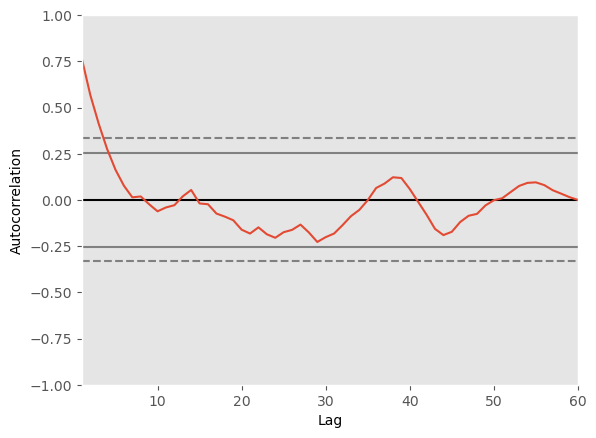

In [1044]:
from pandas.plotting import autocorrelation_plot

# 自己相関のプロット
autocorrelation_plot(D_train['random_walk'])
plt.show()

In [1045]:
# 'random_walk'列の差分を取ります
D_train['random_walk_diff'] = D_train['random_walk'].diff()
D_train = D_train.dropna()
D_train.head()

,x,random_walk,random_walk_diff
2010-07-31,3,2.645161,4.611828
2010-10-31,6,-1.612903,-4.258065
2010-11-30,7,3.033333,4.646237
2011-02-28,10,2.250000,-0.783333
2011-06-30,14,-12.266667,-14.516667


In [1046]:
# 差分を取ったデータが定常性を満たすのかを確認したい
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fullerテストを実行します
result = adfuller(D_train['random_walk_diff'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# p値が0.05以下であれば、定常性を満たすと判断できる


ADF Statistic: -8.428348
p-value: 0.000000


In [1047]:
from sklearn.preprocessing import StandardScaler

# StandardScalerのインスタンスを作成します
scaler = StandardScaler()

# 'random_walk'列を標準化します
D_train['random_walk_scaled'] = scaler.fit_transform(D_train[['random_walk_diff']])

# 結果を表示します
D_train.head()

,x,random_walk,random_walk_diff,random_walk_scaled
2010-07-31,3,2.645161,4.611828,0.846839
2010-10-31,6,-1.612903,-4.258065,-0.769799
2010-11-30,7,3.033333,4.646237,0.853110
2011-02-28,10,2.250000,-0.783333,-0.136490
2011-06-30,14,-12.266667,-14.516667,-2.639544


同じ様に交差検証データとテストデータにも行います．

In [1048]:
# 交差検証データの差分を取る
D_cross['random_walk_diff'] = D_cross['random_walk'].diff()
D_cross = D_cross.dropna()
# テストデータの差分を取る
D_test['random_walk_diff'] = D_test['random_walk'].diff()
D_test = D_test.dropna()

In [1049]:
# 'random_walk'列を標準化します
D_cross['random_walk_scaled'] = scaler.fit_transform(D_cross[['random_walk_diff']])
# 'random_walk'列を標準化します
D_test['random_walk_scaled'] = scaler.fit_transform(D_test[['random_walk_diff']])

In [1050]:
D_cross.head()

,x,random_walk,random_walk_diff,random_walk_scaled
2017-07-31,87,-16.774194,13.290323,1.312464
2018-07-31,99,-22.806452,-6.032258,-0.742038
2016-09-30,77,-16.500000,6.306452,0.569894
2017-05-31,85,-19.354839,-2.854839,-0.404194
2017-01-31,81,-13.354839,6.000000,0.537310


In [1051]:
D_test.head()

,x,random_walk,random_walk_diff,random_walk_scaled
2010-05-31,1,-2.677419,-1.477419,-0.198428
2010-08-31,4,0.096774,2.774194,0.342478
2010-09-30,5,-2.233333,-2.330108,-0.306910
2010-12-31,8,1.935484,4.168817,0.519908
2011-01-31,9,-1.870968,-3.806452,-0.494736


### 差分したデータを可視化

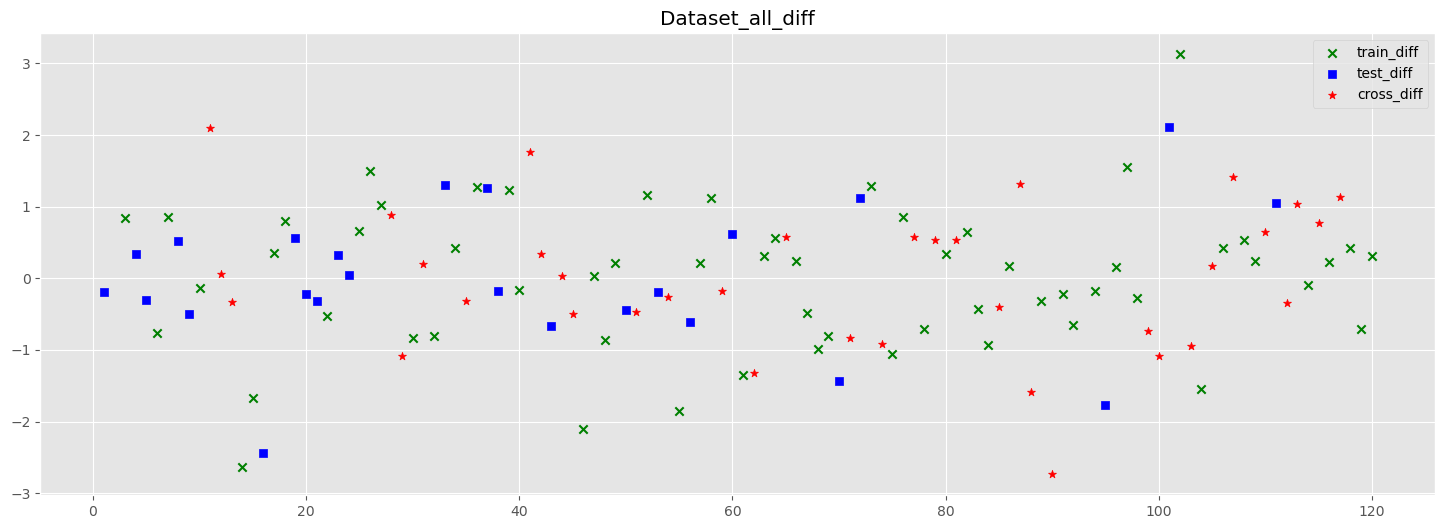

In [1052]:
fig , ax = plt.subplots(figsize=(18, 6))

X_train_diff = D_train["x"]
y_train_diff = D_train["random_walk_scaled"]
X_cross_diff = D_cross["x"]
y_cross_diff = D_cross["random_walk_scaled"]
X_test_diff = D_test["x"]
y_test_diff = D_test["random_walk_scaled"]
ax.scatter(X_train_diff , y_train_diff ,marker='x' , label = 'train_diff',color='green')
ax.scatter(X_test_diff , y_test_diff ,marker='s' ,label = 'test_diff',color='blue')
ax.scatter(X_cross_diff , y_cross_diff ,marker = '*' , label = 'cross_diff' ,color='red')
ax.set_title("Dataset_all_diff")

ax.legend()
plt.show()

この差分を取ったきれいなデータで学習を勧めましょう．

### 実装
関数を定義しましょう．

$$
\phi_h (x) = \exp{\{-\frac{(x-\mu_h)^2}{\sigma^2}\}}\ , \ (h = -H , \frac{1}{H} - H , ... , - \frac{1}{H}+H , H)
$$

In [1053]:
def radial_basis_function(x , mu_h , sigma):
    phi = np.exp(- (x - mu_h / sigma)**2)
    return phi

動径基底関数ベクトルを定義しましょう．
$$
\vec{\phi}(x) = (\phi_{-H}(x) , \phi_{\frac{1}{H} - H}(x) , ... , \phi_{H}(x))^{\top}
$$

In [1054]:
def radial_basis_function_vecteor(x , mu , sigma):
    phi_vector = []
    length = len(mu)
    # ベクトルの各要素に対して基底関数を計算
    for i in range(length) :
        phi_vector.append(radial_basis_function(x , mu[i] , sigma))
    return phi_vector

In [1055]:
mu_h = np.arange(0 , 120 , 1 )
mu_h

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

In [1056]:
sigma = 1

動径基底関数ベクトルを計算してみましょう．
$$
\vec{\phi}(x) = (\phi_{0}(x) , \phi_{1}(x) , ... , \phi_{120}(x))^{\top}
$$

In [1057]:
X_train_diff[0] , y_train_diff[0]

(3, 0.8468385469651466)

In [1058]:
mu_h[0]

0

In [1059]:
# 具体的に3を入れました．
ph = radial_basis_function_vecteor(X_train_diff[0] , mu_h , sigma)
ph[0]

0.00012340980408667956

In [1060]:
#　手計算と一致しているか確認
np.exp(-9)

0.00012340980408667956

次に計画行列を計算しましょう．

つまり，

$$
\vec{f}
=
\begin{pmatrix}
f(x_1) \\
f(x_2)   \\
f(x_3)  \\
・\\
・\\
・\\
f(x_{N_{train}}) \\
\end{pmatrix}
=
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix}
\begin{pmatrix}
w_{-H} \\
w_{\frac{1}{H}-H}\\
・\\
・\\
・\\
w_{H} \\
\end{pmatrix}
$$

における
$$
\Phi = 
\begin{pmatrix}
\vec{\phi}(x_1) \\
\vec{\phi}(x_2) \\
\vec{\phi}(x_3) \\
・\\
・\\
・\\
\vec{\phi}(x_{N_{train}})  \\
\end{pmatrix} 
\ :\  N_{train} × (2H+1)\ 行列
$$

を定義しましょう．


In [1061]:
X_train_diff

2010-07-31      3
2010-10-31      6
2010-11-30      7
2011-02-28     10
2011-06-30     14
2011-07-31     15
2011-09-30     17
2011-10-31     18
2012-02-29     22
2012-05-31     25
2012-06-30     26
2012-07-31     27
2012-10-31     30
2012-12-31     32
2013-02-28     34
2013-04-30     36
2013-07-31     39
2013-08-31     40
2014-02-28     46
2014-03-31     47
2014-04-30     48
2014-05-31     49
2014-08-31     52
2014-11-30     55
2015-01-31     57
2015-02-28     58
2015-05-31     61
2015-07-31     63
2015-08-31     64
2015-10-31     66
2015-11-30     67
2015-12-31     68
2016-01-31     69
2016-05-31     73
2016-07-31     75
2016-08-31     76
2016-10-31     78
2016-12-31     80
2017-02-28     82
2017-03-31     83
2017-04-30     84
2017-06-30     86
2017-09-30     89
2017-11-30     91
2017-12-31     92
2018-02-28     94
2018-04-30     96
2018-05-31     97
2018-06-30     98
2018-10-31    102
2018-12-31    104
2019-02-28    106
2019-04-30    108
2019-05-31    109
2019-10-31    114
2019-12-31

In [1062]:
def design_matrix(x_RBF , mu_h , sigma):
    phi = []
    for i in range(len(x_RBF)):
        phi.append(radial_basis_function_vecteor(x_RBF[i] , mu_h , sigma))
    return phi

データを入れて形状を見ましょう

In [1063]:
Phi = design_matrix(X_train_diff , mu_h , sigma)
Phi_np = np.array(Phi)
Phi_np.shape

(59, 120)

In [1064]:
Phi_np

array([[1.23409804e-04, 1.83156389e-02, 3.67879441e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.31952283e-16, 1.38879439e-11, 1.12535175e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.24288566e-22, 2.31952283e-16, 1.38879439e-11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.67879441e-01, 1.00000000e+00, 3.67879441e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.83156389e-02, 3.67879441e-01, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.23409804e-04, 1.83156389e-02, 3.67879441e-01]])

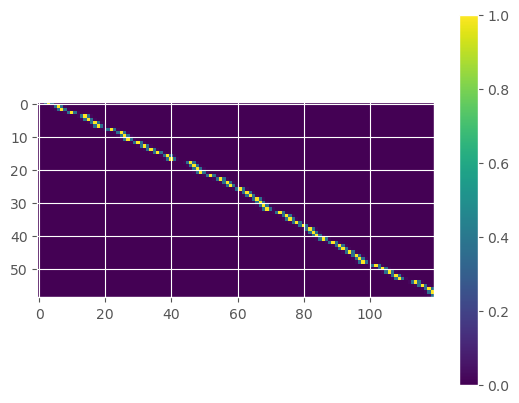

In [1065]:
fig, ax = plt.subplots( )
im = ax.imshow(Phi)
fig.colorbar(im, ax=ax)
plt.show()

次に計画行列の積
$$
\Phi^{\top} \Phi
$$

の計算をしましょう

In [1066]:
Phi_dot = np.dot(Phi_np.T , Phi_np)
Phi_dot

array([[1.52299797e-08, 2.26032941e-06, 4.53999298e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.26032941e-06, 3.35462628e-04, 6.73794700e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.53999298e-05, 6.73794700e-03, 1.35335283e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.71006060e-01, 3.81357596e-01, 1.53741722e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.81357596e-01, 1.13600621e+00, 7.42499090e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.53741722e-01, 7.42499090e-01, 1.27067058e+00]])

In [1067]:
Phi_dot.shape

(120, 120)

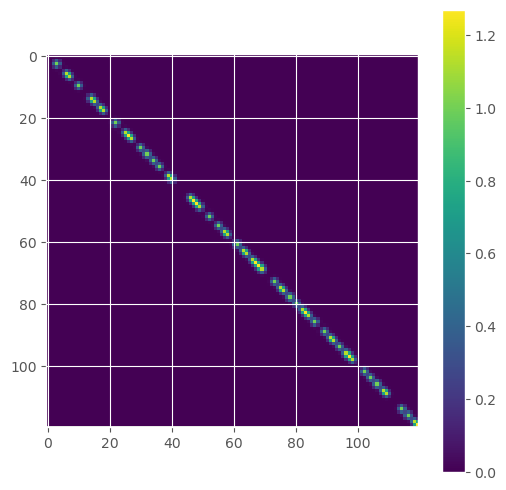

In [1068]:
fig, ax = plt.subplots(figsize=(6, 6) )

im = ax.imshow(Phi_dot)
fig.colorbar(im, ax=ax)
plt.show()

最後に
$$
\hat{w}=(\Phi^{\top} \Phi + \alpha I)^{-1}\Phi^{\top} \vec{y}
$$
を計算すればパラメータの最尤解を求めることができます．

In [1069]:
y_train_diff

2010-07-31    0.846839
2010-10-31   -0.769799
2010-11-30    0.853110
2011-02-28   -0.136490
2011-06-30   -2.639544
2011-07-31   -1.673657
2011-09-30    0.355713
2011-10-31    0.797452
2012-02-29   -0.530771
2012-05-31    0.660921
2012-06-30    1.491220
2012-07-31    1.020085
2012-10-31   -0.834472
2012-12-31   -0.799196
2013-02-28    0.424768
2013-04-30    1.277336
2013-07-31    1.227039
2013-08-31   -0.164221
2014-02-28   -2.100221
2014-03-31    0.025599
2014-04-30   -0.858381
2014-05-31    0.218331
2014-08-31    1.158642
2014-11-30   -1.850235
2015-01-31    0.216568
2015-02-28    1.126936
2015-05-31   -1.349549
2015-07-31    0.317889
2015-08-31    0.564824
2015-10-31    0.241457
2015-11-30   -0.490919
2015-12-31   -0.989884
2016-01-31   -0.810954
2016-05-31    1.287989
2016-07-31   -1.057889
2016-08-31    0.852914
2016-10-31   -0.711005
2016-12-31    0.335527
2017-02-28    0.647975
2017-03-31   -0.429634
2017-04-30   -0.933442
2017-06-30    0.176392
2017-09-30   -0.315713
2017-11-30 

In [1070]:
alpha = 0.1

In [1071]:
Phi_dot_inv = np.linalg.inv(Phi_dot)
Phi_dot_inv_ridge = np.linalg.inv(Phi_dot + alpha * np.identity(Phi_dot.shape[0]))
omega = np.dot(Phi_dot_inv_ridge , np.dot(Phi_np.T , y_train_diff))

$$
\Phi^{\top} \Phi + \alpha I
$$

の可視化をしましょう

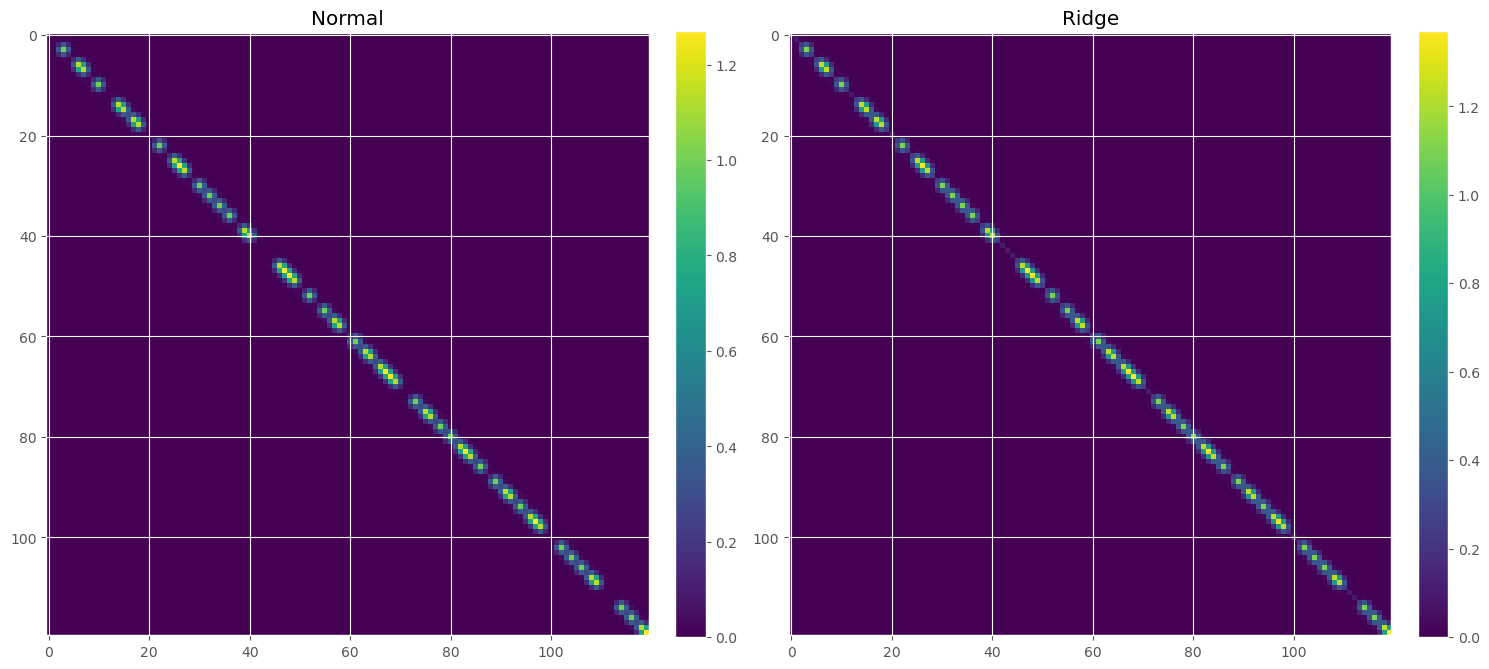

In [1072]:
fig, axes = plt.subplots(figsize=(15, 7), ncols = 2)

im_1 = axes[0].imshow(Phi_dot, aspect='equal')
axes[0].set_title('Normal')
fig.colorbar(im_1, ax=axes[0], fraction=0.046, pad=0.04)

im_2 = axes[1].imshow(np.linalg.inv(Phi_dot_inv_ridge), aspect='equal')
axes[1].set_title('Ridge')
fig.colorbar(im_2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

右のヒートマップでは，薄くはありますが値があることがわかります．

逆行列も可視化しましょう

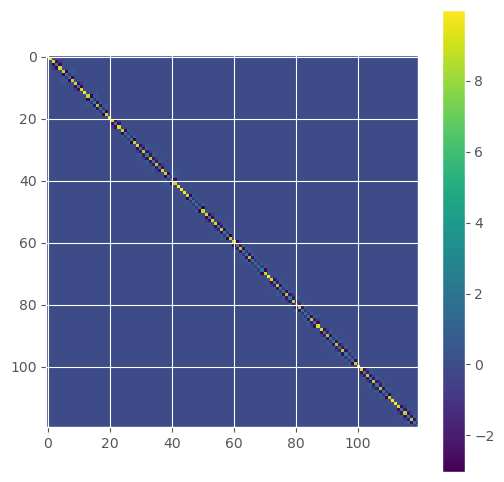

In [1073]:
fig, ax = plt.subplots(figsize=(6, 6) )

im = ax.imshow(Phi_dot_inv_ridge)
fig.colorbar(im, ax=ax)
plt.show()

ある説明変数点$x^*$が与えられたときの，予測値を計算しましょう．

つまり
$$
f(x^*) = \hat{w}^{\top} \vec{\phi}(x^*)
$$

In [1074]:
ph_new = radial_basis_function_vecteor(X_test_diff[12] , mu_h , sigma)
y_new = np.dot(omega , ph_new)
y_new , y_test_diff[12]

(0.8880992814119968, 1.2576687418435544)

In [1075]:
y_new = np.zeros(len(X_test_diff))
for i in range(len(X_test_diff)):
    ph_new = radial_basis_function_vecteor(X_test_diff[i] , mu_h , sigma)
    y_new[i] = np.dot(omega , ph_new)

y_new

array([ 0.10840133,  0.26761445, -0.63252619,  0.75469542,  0.12727703,
       -0.40243643,  0.43642419,  0.03537857, -0.28147566, -0.29355715,
        0.03518668, -0.20576024,  0.88809928,  1.0204339 , -0.04690503,
        0.6215195 ,  0.40451834, -0.98668965, -0.60233473, -0.30268268,
        0.83513238, -0.37020882,  1.81053583,  0.00216108])

グラフ化しましょう．

Text(0.5, 1.0, 'RBF')

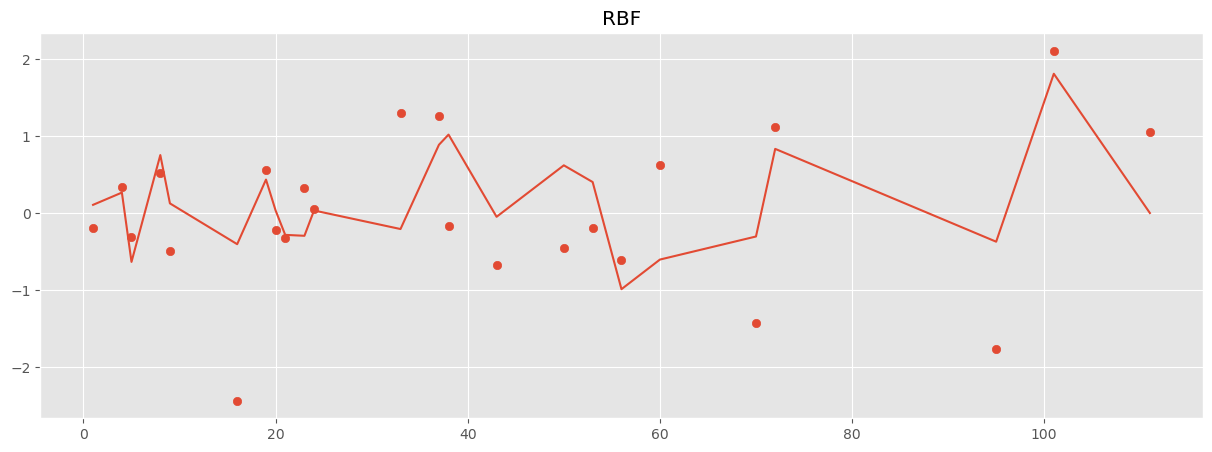

In [1076]:
fig , ax = plt.subplots(figsize=(15, 5))
ax.plot(X_test_diff , y_new , label = "predict")
ax.scatter(X_test_diff , y_test_diff , label = "test")
ax.set_title("RBF")

以上が基底関数回帰の一連の流れです．

お疲れ様でした．

# 教科書3.4と3.5のモデルをそのまま採用したコード

## 教科書3.4　ガウス過程回帰の実装
教科書P81の内容にそってガウス過程回帰の実装を行います．

参考

https://qiita.com/ogi-iii/items/cf16e13ec09340016121

時系列解析

https://qiita.com/DS27/items/1e998a58488e76bfcbdc

### カーネルの学習

データセット$\mathcal{D} = \{ (x_n , y_n ) \} _{n = 1,...,N}$が与えられています．

今で言うところのD_trainです．

このデータセットからカーネル$K$を計算し，$\vec{y}$の分布を算出します．<=最初の目標


まずはデータの可視化，分析です．

In [1077]:
X_train = D_train["x"]
y_train = D_train["random_walk_scaled"]
X_cross = D_cross["x"]
y_cross = D_cross["random_walk_scaled"]
X_test = D_test["x"]
y_test = D_test["random_walk_scaled"]

In [1078]:
# データセットD
D_train.head()

,x,random_walk,random_walk_diff,random_walk_scaled
2010-07-31,3,2.645161,4.611828,0.846839
2010-10-31,6,-1.612903,-4.258065,-0.769799
2010-11-30,7,3.033333,4.646237,0.853110
2011-02-28,10,2.250000,-0.783333,-0.136490
2011-06-30,14,-12.266667,-14.516667,-2.639544


Text(0.5, 1.0, 'Dataset_Train')

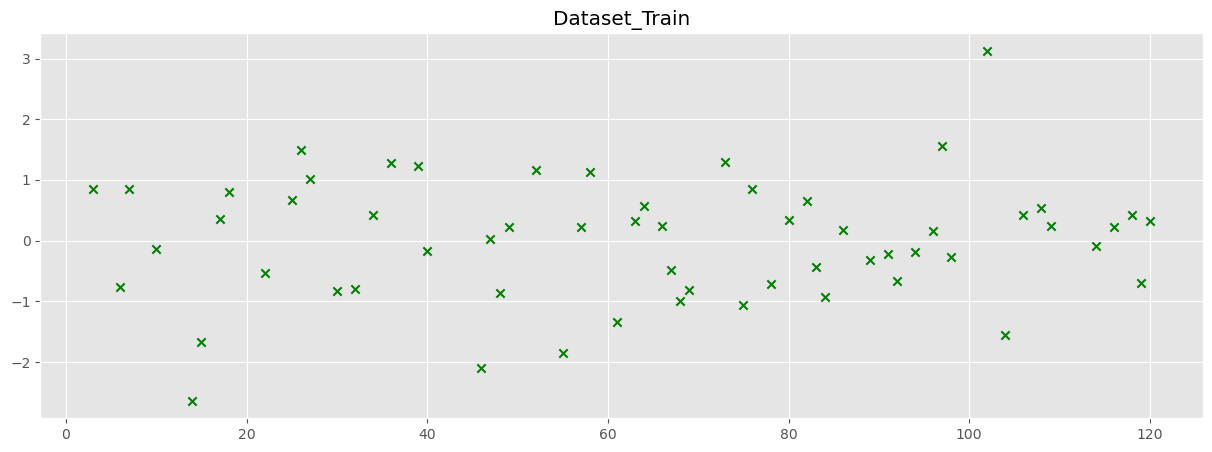

In [1079]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(15, 5))

ax.scatter(X_train , y_train , marker='x' , color='green')
ax.set_title("Dataset_Train")

#### ここからガウス過程の実装です．

このとき$y_n = f(x_n)$という関係が成り立つとしましょう．

そして，$f$はガウス過程
$$
f～GP(\vec{0} , k(\vec{x},\vec{x}^{'} ))
$$

このとき$y$についてデータをN個を並べたベクトル$\vec{y}$の分布は
$$
\vec{y}～\mathcal{N} (\vec{0} , K)
$$
となります．

ただし，今回カーネルは以下のように定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

まず学習するのは，$\vec{y}$の分布です．

つまり
$$
\vec{y}～\mathcal{N} (\vec{0} , K)
$$
にある$K$の部分を訓練データから学習します．

つまり，訓練データの数を$N_{train}$とすると
$$
K^{(train) } = 
\begin{pmatrix}
k(x_1 , x_1) & k(x_1,x_2) & k(x_1,x_3) & ・・・ & k(x_1,x_{N_{train}}) \\
k(x_2,x_1)  & k(x_2,x_2) & k(x_2,x_3) & ・・・ & k(x_2,x_{N_{train}})  \\
k(x_3,x_1)  & k(x_3,x_2) & k(x_3,x_3) & ・・・ & k(x_3,x_{N_{train}}) \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
k(x_{N_{train} }, x_1) & k(x_{N_{train}} , x_2) & k(x_{N_{train}} , x_3) & ・・・ & k(x_{N_{train}} , x_{N_{train}}) \\
\end{pmatrix}
$$

を計算しましょうということです．

まずは以下の関数を定義します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

In [1080]:
# パラメータ値
Theta_1 = 1.0
Theta_2 = 2.0
Theta_3 = 0.01

In [1081]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) 
    return kernel

実際に理論計算をして確かめてみましょう．

In [1082]:
a = kernel(1,1,Theta_1,Theta_2,Theta_3)
a

1.01

In [1083]:
b = kernel(1,2,Theta_1,Theta_2,Theta_3)
b

0.6065306597126334

手計算と一致していましたか？

これらを計算したら，次はカーネルの各成分に代入して上げましょう．

それが訓練データから学習したカーネルになります．

In [1084]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3)
    return K

In [1085]:
%time  K = compute_kernel(X_train , Theta_1 , Theta_2 , Theta_3)
K.shape

CPU times: user 17.4 ms, sys: 44 µs, total: 17.4 ms
Wall time: 17.2 ms


(59, 59)

数値を見てもカーネルをイメージすることはできません．カーネルをヒートマップで可視化をしましょう．

ヒートマップの作り方は以下のサイトが参考になります．

https://dreamer-uma.com/matplotlib-imshow/

In [1086]:
K

array([[1.01000000e+00, 1.11089965e-02, 3.35462628e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11089965e-02, 1.01000000e+00, 6.06530660e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.35462628e-04, 6.06530660e-01, 1.01000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.01000000e+00, 6.06530660e-01, 1.35335283e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06530660e-01, 1.01000000e+00, 6.06530660e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.35335283e-01, 6.06530660e-01, 1.01000000e+00]])

In [1087]:
for j in range(len(X_train)):
    K_1[j , j] = 0

K_1

array([[0.00000000e+00, 1.11089965e-02, 3.35462628e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11089965e-02, 0.00000000e+00, 6.06530660e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.35462628e-04, 6.06530660e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.06530660e-01, 1.35335283e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.06530660e-01, 0.00000000e+00, 6.06530660e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.35335283e-01, 6.06530660e-01, 0.00000000e+00]])

以下が学習したカーネル$K$(分散共分散行列)の可視化です．

左が完全なカーネル，右が対角成分を除いたカーネルです．

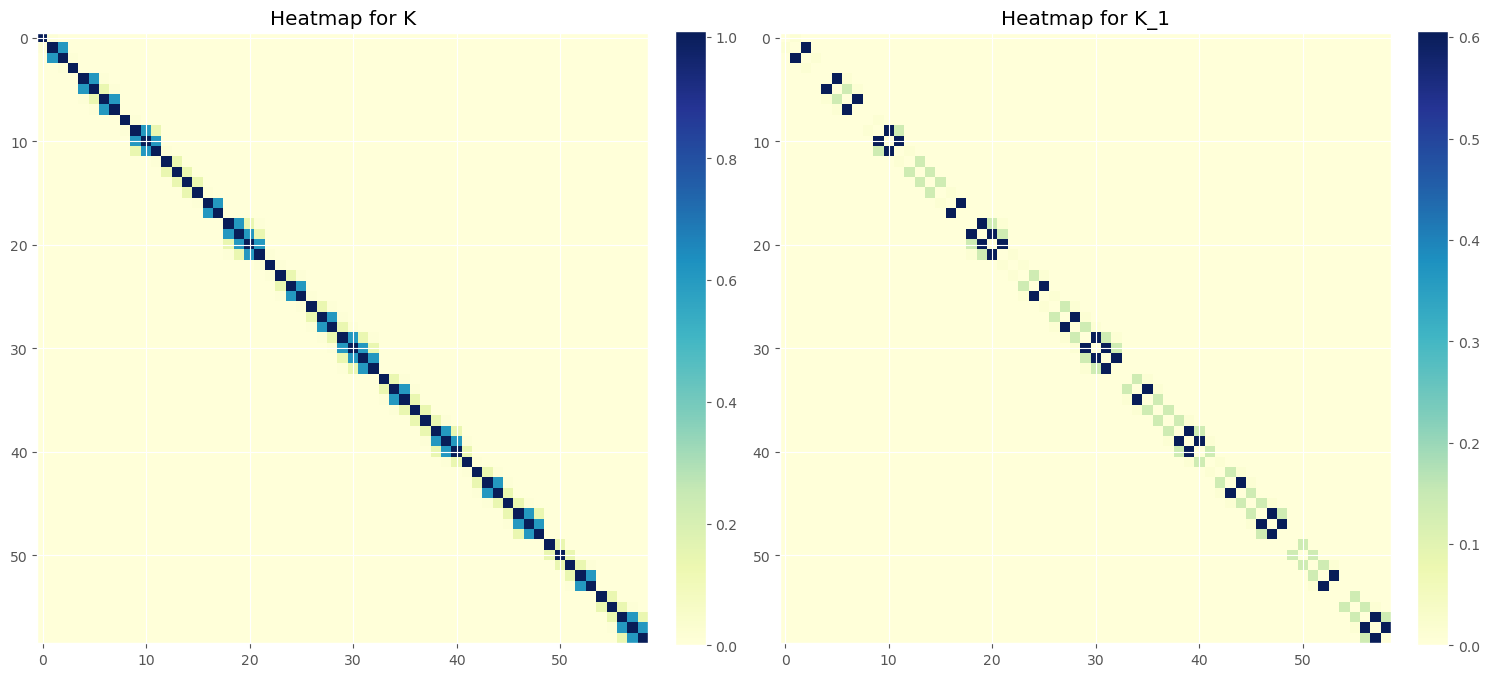

In [1088]:
fig, axes = plt.subplots(figsize=(15, 7), ncols = 2)

im_1 = axes[0].imshow(K, aspect='equal', cmap='YlGnBu')
axes[0].set_title('Heatmap for K')
fig.colorbar(im_1, ax=axes[0], fraction=0.046, pad=0.04)

im_2 = axes[1].imshow(K_1, aspect='equal', cmap='YlGnBu')
axes[1].set_title('Heatmap for K_1')
fig.colorbar(im_2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

このような分散共分散行列をもつ$\vec{y}$の分布が学習できました．

### テストデータへのあてはめ
テストデータを用いて予測分布を計算し，関数の雲を作りたいです．

まずはデータセットを見てみましょう．

In [1089]:
D_test.head()

,x,random_walk,random_walk_diff,random_walk_scaled
2010-05-31,1,-2.677419,-1.477419,-0.198428
2010-08-31,4,0.096774,2.774194,0.342478
2010-09-30,5,-2.233333,-2.330108,-0.306910
2010-12-31,8,1.935484,4.168817,0.519908
2011-01-31,9,-1.870968,-3.806452,-0.494736


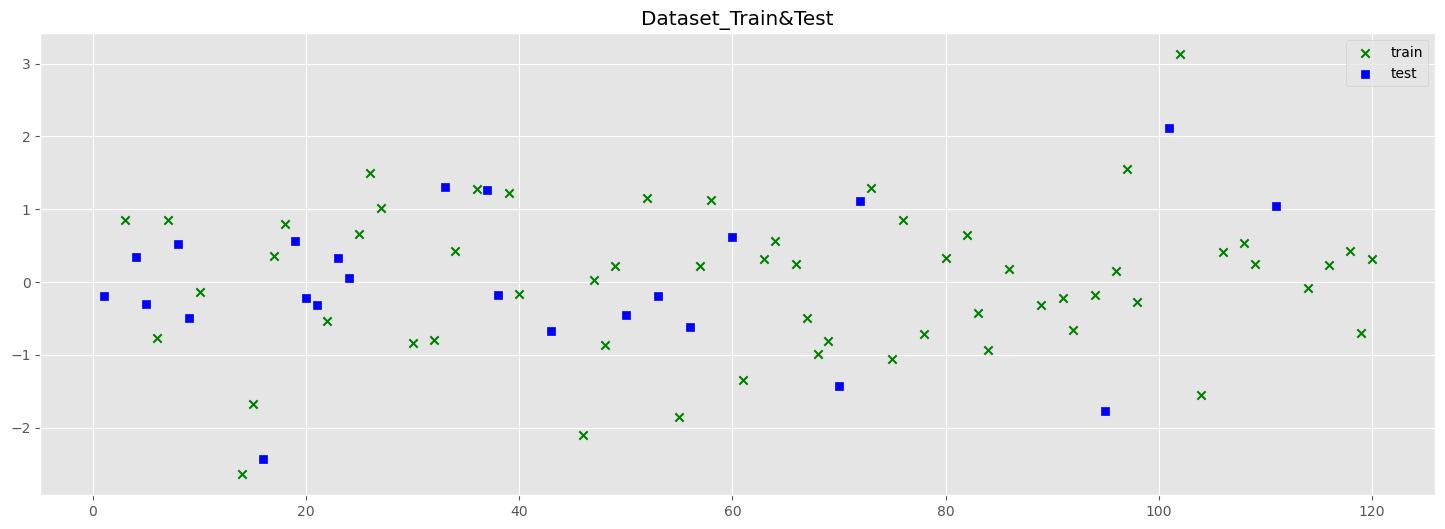

In [1090]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

ax.scatter(X_train , y_train,marker='x' , label = 'train',color='green')
ax.scatter(X_test , y_test,marker='s' ,label = 'test',color='blue')
ax.set_title("Dataset_Train&Test")

ax.legend()
plt.show()

### 予測分布の計算

予測したいテストデータ$X^{*} = (x^{*}_1 , ... ,x^{*}_{N_{test}})$と予測したい出力 $\vec{y}^{*} = (y^{*}_1 , ... ,y^{*}_{N_{test}})$とします．

ここではD_testです．

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | \vec{x}^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$定義して

期待値と分散をそれぞれ計算することで，上の予測分布を計算することができます．

ここで$\textbf{k}_*$について復習しましょう．以下のようなベクトルになります．定義して
$$
\textbf{k}_* = (k(x^*,x_1) , k(x^*,x_2) , k(x^*,x_3) ,.... ,k(x^*,x_{N_{train}}))\top
$$

次に$k_{**}$について復習しましょう．
$$
k_{**} = k(x^*,x^*)
$$

まずは，頻繁に使う$K^{-1}\vec{y}$を計算します．

In [1091]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy
np.linalg.inv(K)

array([[ 9.90279771e-01, -1.67277501e-02,  9.71764068e-03, ...,
         1.44080721e-65, -1.06140544e-65,  4.46517721e-66],
       [-1.67277501e-02,  1.54893380e+00, -9.30275426e-01, ...,
        -1.38176873e-63,  1.01791331e-63, -4.28221221e-64],
       [ 9.71764068e-03, -9.30275426e-01,  1.54893380e+00, ...,
         2.37854924e-63, -1.75221575e-63,  7.37131504e-64],
       ...,
       [ 1.44080721e-65, -1.38176873e-63,  2.37854924e-63, ...,
         1.82308636e+00, -1.47895984e+00,  6.43945061e-01],
       [-1.06140544e-65,  1.01791331e-63, -1.75221575e-63, ...,
        -1.47895984e+00,  2.74863436e+00, -1.45250799e+00],
       [ 4.46517721e-66, -4.28221221e-64,  7.37131504e-64, ...,
         6.43945061e-01, -1.45250799e+00,  1.77610530e+00]])

In [1092]:
yy = Expected_train(K , y_train)
np.dot(yy,yy)

213.36764054700285

それでは予測分布の計算に移ります．

分布は正規分布

期待値は$\textbf{k}^{\top}_* K^{-1} \vec{y} $

分散は$\textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*$

つまり
$$
p(y^{*} | X^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$

を計算します．

まずは最初のテストデータを用いて計算を実行してみましょう．

In [1093]:
x_asterisk , y_asterisk = X_test[0] , y_test[0]
x_asterisk , y_asterisk

(1, -0.19842807527536574)

$\textbf{k}_* = (k(x^*,x_1) , k(x^*,x_2) , k(x^*,x_3) ,.... ,k(x^*,x_{N_{train}}))\top$
の計算です．

In [1094]:
# テストデータとトレーニングデータ間のカーネル行列の下地を準備
k = np.zeros(len(X_train))

for x in range(len(X_train)):
# 訓練データとテストデータのカーネル
    k[x] = kernel(X_train[x], x_asterisk, Theta_1, Theta_2, Theta_3)
    

k

array([1.35335283e-001, 3.72665317e-006, 1.52299797e-008, 2.57675711e-018,
       2.00500878e-037, 2.74878501e-043, 2.57220937e-056, 1.75568810e-063,
       1.73008221e-096, 8.37894253e-126, 1.91855567e-136, 1.61608841e-147,
       2.39425476e-183, 2.09653176e-209, 3.36244047e-237, 9.87710872e-267,
       2.75032531e-314, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

$k_{**} = k(x^*,x^*)$
の計算をしましょう．

In [1095]:
#テストデータ同士のカーネル
s = kernel(x_asterisk, x_asterisk, Theta_1, Theta_2, Theta_3) # (3.69)式
s

1.01

手計算と同じになりましたか？

それではテストデータの分を回して，それぞれの説明変数における予測分布を計算しましょう．

In [1096]:
# 予測分布の期待値，分散の計算
def predict(X_train , X_test , Theta_1 , Theta_2 , Theta_3) :
    # 平均
    mu = []
    # 分散
    var = []

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3) # (3.69)式

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

定義した関数を使って実行してみましょう．

In [1097]:
mu , var = predict(X_train , X_test , Theta_1 , Theta_2 , Theta_3) 

結果はどうなっているでしょうか？

可視化を試みましょう．

可視化するのは，予測分布の期待値と標準偏差の2倍です．

In [1098]:
# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train , y_train , X_test , y_test , mu , var ):
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
    
    # 元の信号
    plt.plot(X_train ,y_train, 'x', color='green', label='correct signal')
    # 正解のプロット
    plt.scatter(X_test, y_test , marker='s' , color='blue', label='signal')
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='mean by Gaussian process')
    
    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu + 2 * std, mu - 2 * std, alpha=0.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

    # 平均値±(標準偏差×2) … 95%の確率で範囲内に指定の数値が現れる

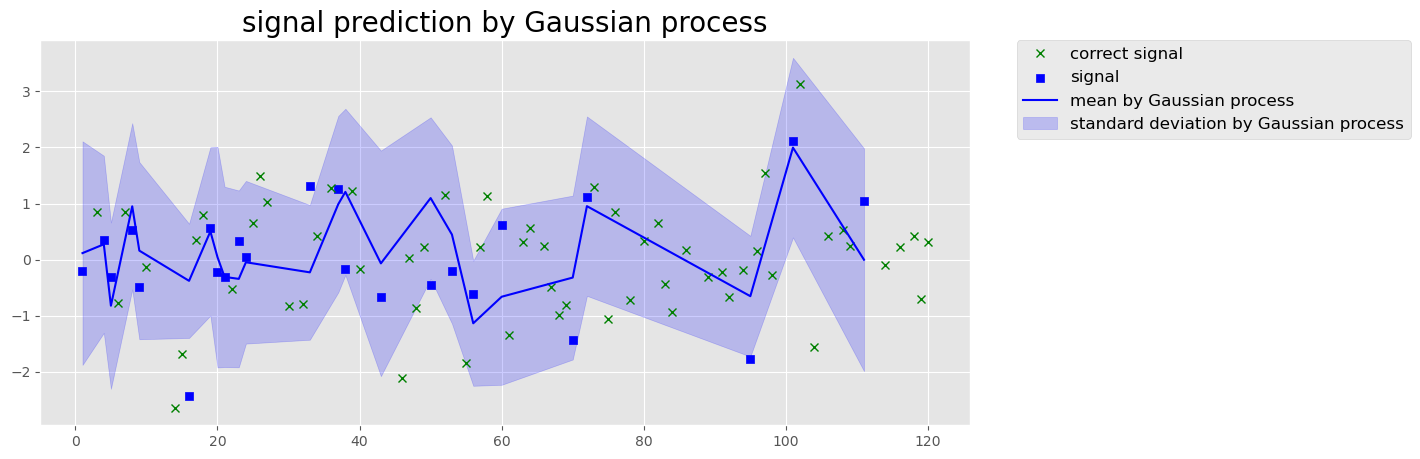

In [1099]:
Gaussian_result(X_train , y_train , X_test , y_test , mu , var )

可視化に成功しました．

青い雲，つまり"standard deviation by Gaussian process"はどのような意味があるでしょうか？

すなわち『ガウス分布における標準偏差の2倍』とはどのような意味でしょうか？

それは，約95％の範囲をあらわしています．

つまり，$\textbf{青色の雲は95％の確率でその中に目的変数が入るという印}$ということになります．

しかし，結果はどうでしょうか？ある程度予測が正しいところもありますが，できていないところも見受けられます．

つまり今のままではいけません！！！！

$後半へ続く$

## 一旦まとめ
これでガウス過程回帰はひとまず終了です．お疲れ様でした．

データの前処理をして，定常分布にするとガウス過程回帰は強力な威力を発揮します．

今までやってきたことをまとめてみましょう．

### カーネルの定義
まずはカーネルの定義です．このカーネルを持ったガウス過程を我々はモデル化します．
$$
k(x , x^{'}) = \theta_1 \exp{\left( - \frac{(x - x^{'})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{'})
$$

### 訓練データからカーネルを計算
モデル化したカーネルを使い，訓練データを用いてフィッティングします．
$$
K^{(train) } = 
\begin{pmatrix}
k(x_1 , x_1) & k(x_1,x_2) & k(x_1,x_3) & ・・・ & k(x_1,x_{N_{train}}) \\
k(x_2,x_1)  & k(x_2,x_2) & k(x_2,x_3) & ・・・ & k(x_2,x_{N_{train}})  \\
k(x_3,x_1)  & k(x_3,x_2) & k(x_3,x_3) & ・・・ & k(x_3,x_{N_{train}}) \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
k(x_{N_{train} }, x_1) & k(x_{N_{train}} , x_2) & k(x_{N_{train}} , x_3) & ・・・ & k(x_{N_{train}} , x_{N_{train}}) \\
\end{pmatrix}
$$

### 予測分布の計算
テストデータを用いて，各説明変数における目的変数の分布を計算します．具体的には，
$$
\begin{cases}
    \mathbf{k}_* = (k(x^*,x_1) , k(x^*,x_2) , k(x^*,x_3) ,.... ,k(x^*,x_{N_{\text{train}}}))^\top, \\
    k_{**} = k(x^*,x^*)
\end{cases}
$$

と定義して，学習したカーネル$K$と訓練データの教師データを用いて以下のように予測分布を出します．
$$
p(y^{*} | \vec{x}^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$

### 予測分布の可視化
各点にガウス分布を定義できたら，それを可視化しました．可視化したのは期待値と標準偏差を2倍した範囲です．

# モデルの改良
ガウス過程回帰でうまく行かない理由は以下の2つがあげられます．
$$
\begin{cases}
    1.パラメータの値が悪い \\
    2.モデル化したカーネルが的を得ていない
\end{cases}
$$

これらを改良してガウス過程がうまく行くようにしましょう．

## 教科書3.5　パラメータ更新の実装
まずはうまく行かない理由1の改良から始めましょう．

### パラメータの学習
カーネルのモデル化はある程度的を得ているとして，パラメータを更新することでよりよいモデルを作っていくことを目指します．

やり方はズバリ$\textbf{最尤法}$です！

方法は，交差検証データを用いて勾配法によるパラメータの更新をします．

In [1100]:
X_train = D_train["x"]
y_train = D_train["random_walk_scaled"]
X_cross = D_cross["x"]
y_cross = D_cross["random_walk_scaled"]
X_test = D_test["x"]
y_test = D_test["random_walk_scaled"]

In [1101]:
D_cross.head() # 並び替えはしていない，理由は確率的勾配法みたいになるかと思って

,x,random_walk,random_walk_diff,random_walk_scaled
2017-07-31,87,-16.774194,13.290323,1.312464
2018-07-31,99,-22.806452,-6.032258,-0.742038
2016-09-30,77,-16.500000,6.306452,0.569894
2017-05-31,85,-19.354839,-2.854839,-0.404194
2017-01-31,81,-13.354839,6.000000,0.537310


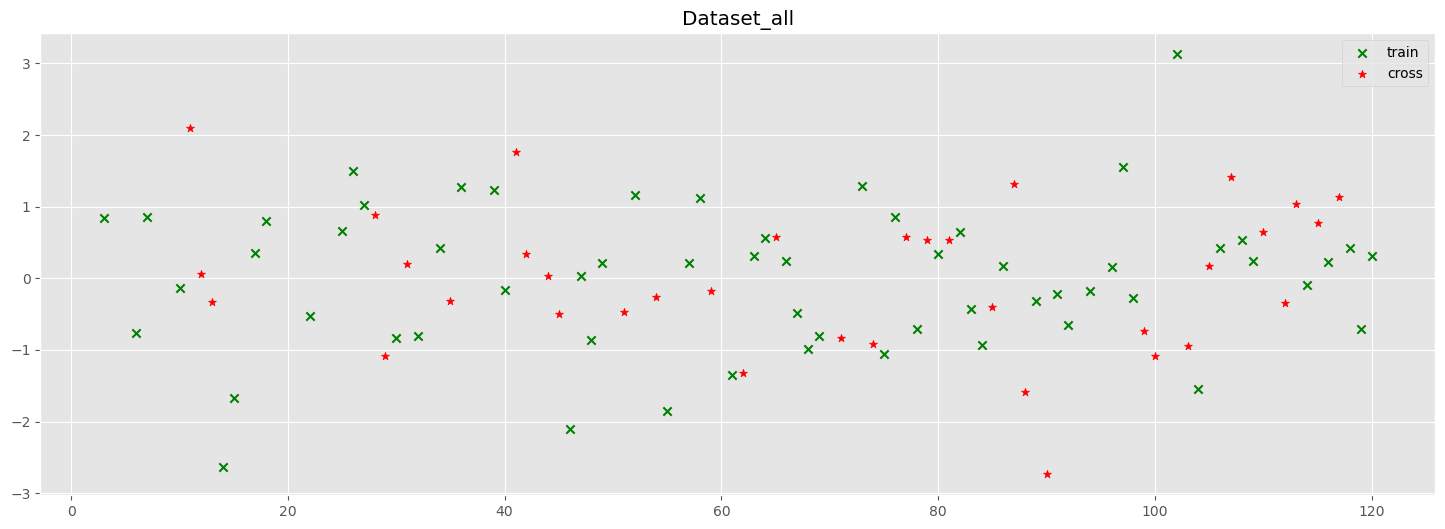

In [1102]:
# coding: utf-8
fig , ax = plt.subplots(figsize=(18, 6))

ax.scatter(X_train , y_train,marker='x' , label = 'train',color='green')
ax.scatter(X_cross , y_cross ,marker = '*' , label = 'cross' ,color='red')
ax.set_title("Dataset_all")

ax.legend()
plt.show()

### 勾配法の復習
大きくしたい関数$E$に対して以下の更新式で勾配を求めるのでした
$$
更新式\ \ ;\ \ \vec{w}^{(\tau)} = \vec{w}^{(\tau - 1)} - \alpha \nabla_{\vec{w}} E
$$
ということで尤度関数の勾配を求めましょう．

#### 更新式の確認
計算は大変ですので認めるのが無難です．

$\tau = \log{\theta_1},\sigma = \log{\theta_2},\eta = \log{\theta_3} $として
$$
k(x , x^{'}) = e^{\tau} \exp{\left( - \frac{(x - x^{'})}{e^{\sigma}} \right)} + e^{\eta} \delta(x , x^{'})
$$

それぞれのカーネルに対する偏微分は
$$
\frac{\partial K_{(n,n^{'})}}{\partial \tau} =  K_{(n,n^{'})} - e^{\eta} \delta{(x , x^{'})}
$$ 
$$
\frac{\partial K_{(n,n^{'})}}{\partial \sigma} =  \left(K_{(n,n^{'})} - e^{\eta} \delta{(n,n^{'})} \right) e^{-\sigma}(x_n - x_{n^{'}})^2
$$ 
$$
\frac{\partial K_{(n,n^{'})}}{\partial \eta} =  e^{\eta} \delta{(x , x^{'})}
$$ 

これらの値を用いた更新式を確認しましょう．

$\tau$を具体例に，$l$を更新回数，$\alpha$を学習率として
$$
\tau^{(l)} = \tau^{(l - 1)} + \alpha  \frac{\partial L(\tau^{(l-1)},\sigma^{(l-1)},\eta^{(l-1)})}{\partial \tau^{(l-1)}}  
$$
$$
\frac{\partial L(\tau^{l-1},\sigma^{l-1},\eta^{l-1})}{\partial \tau^{l-1}}  = - \operatorname{tr}\left\{ K^{-1}_{\theta^{(l-1) }} \frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}}\right\} + (K^{-1}_{\theta^{(l-1)}} \vec{y})^{\top} \frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}} K^{-1}_{\theta^{(l-1)}} \vec{y}
$$
$$
\frac{\partial K^{-1}_{\theta^{(l-1)}}}{\partial \tau^{(l-1)}}=
K^{(l-1)} - \exp{(\eta^{(l-1)})} I
$$

こんな感じで勾配法を用いて実装します．

式は難しいですがゼロつくと同じです！

In [1103]:
X_train.shape , K.shape

((59,), (59, 59))

最初にカーネル行列の更新をするプログラムを作成します．

行列$X$やベクトル$y$などは更新しやすいですが，カーネル行列は大変だからです．

In [1104]:
# カーネル行列の更新
def kernel_new(X_old , X_cross ,  l  , K_old ):
    l = l - 1
    train_length = len(X_old)
    length = train_length
    k = np.zeros(length)
    for x in range(train_length):
        k[x] = kernel(X_old[x], X_cross[l], Theta_1, Theta_2, Theta_3)
    K_new = np.vstack([K_old , k])
    
    s = kernel(X_cross[l], X_cross[l], Theta_1, Theta_2, Theta_3)
    k = np.append(k, s)
    k = k[:,np.newaxis]
    K_new = np.hstack([K_new , k])
    return K_new

次に対数尤度関数に対するパラメータの勾配を求めるプログラムを作成しましょう．

In [1105]:
# tauの偏微分の計算
def Tau_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3):

    # X_train : (N + l - 1) × 1
    # K_old : (N + l - 1) × (N + l - 1)
    # y_old : (N + l - 1) × 1
    
    l = l
    old_length = len(X_old)
    length = old_length + l
    
    
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    I = np.eye(length - l)
    yK = Expected_train(K_old , y_old)
    
    tau_grad = - 1 * np.trace( I - Theta_3 * np.linalg.inv(K_old)) + np.dot(yK , y_old) - Theta_3 * np.dot(yK , yK)
    return tau_grad

勾配の実際の値を計算してみましょう．

In [1106]:
yK = Expected_train(K, y_train)
np.dot(yK , yK )

213.36764054700285

勾配がめちゃくちゃ大きくて不安ですが続けます．

In [1107]:
I = np.eye(len(X_train))
np.trace( I - Theta_3 * np.linalg.inv(K))

58.04325812907889

In [1108]:
np.dot(yK , y_train)

80.22599386746026

その他の微分を計算しましょう．

In [1109]:
# sigmaの偏微分の計算
def Distance_matrix(X_train):
    lenght = len(X_train)
    distance_matrix = np.zeros((lenght ,lenght))
    
    for x in range(lenght):
        for x_prime in range(lenght):
            X = X_train[x]
            X_prime = X_train[x_prime]
            distance_matrix[x , x_prime] = ( X - X_prime ) ** 2
    
    return distance_matrix

def New_distance_matrix( X_old ,  X_cross , l , distance_matrix_old ): # l：更新回数
    l = l - 1
    length = len(X_old)
    k = np.zeros(length)
    for x in range(length):
        X = X_old[x]
        X_prime = X_cross[l]
        k[x] = ( X - X_prime ) ** 2
    K_new = np.vstack([distance_matrix_old , k]) # 最後の行に追加
    
    s = 0
    k = np.append(k, s)
    k = k[:,np.newaxis] # (N + l - 1 ) × 1　の行列にする 
    distance_matrix_new = np.hstack([K_new , k]) # 最後の列に追加
    return distance_matrix_new

def Sigma_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3 , distance_matrix_old):
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3) 
    mai = 1 / Theta_2
    # 更新回数の確認
    l = l
    old_length = len(X_old)
    length = old_length + l
    
    d = distance_matrix_old
    yK = Expected_train(K_old , y_old)
    K_mai = np.linalg.inv(K_old)
    
    sigma_grad = - np.trace(mai * np.dot(K_mai,d) - Theta_3 * mai * np.dot(K_mai , d)) \
                + mai * np.dot( yK , np.dot( np.dot(K_old , d) , yK ) ) \
                - Theta_3 * mai * np.dot(yK , np.dot(d,yK)) 
    return sigma_grad 

In [1110]:
d = Distance_matrix(X_train)
d

array([[0.0000e+00, 9.0000e+00, 1.6000e+01, ..., 1.3225e+04, 1.3456e+04,
        1.3689e+04],
       [9.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.2544e+04, 1.2769e+04,
        1.2996e+04],
       [1.6000e+01, 1.0000e+00, 0.0000e+00, ..., 1.2321e+04, 1.2544e+04,
        1.2769e+04],
       ...,
       [1.3225e+04, 1.2544e+04, 1.2321e+04, ..., 0.0000e+00, 1.0000e+00,
        4.0000e+00],
       [1.3456e+04, 1.2769e+04, 1.2544e+04, ..., 1.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.3689e+04, 1.2996e+04, 1.2769e+04, ..., 4.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [1111]:
np.trace((1/Theta_2) * np.dot(np.linalg.inv(K),d) - Theta_3 * (1/Theta_2) * np.dot(np.linalg.inv(K) , d)) ,\
(1/Theta_2) * np.dot( yK , np.dot( np.dot(K , d) , yK ) ) , Theta_3 * ( 1 / Theta_2) * np.dot(yK , np.dot(d,yK)) 

(-15.793039556217769, -21885.48689111373, -207.52889221249214)

In [1112]:
# etaの偏微分の計算
def Eta_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3):
    # パラメータの再定義
    tau , sig , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    # 学習回数の確認
    old_length = len(X_old)
    length = old_length + l
    # 計算に必要なベクトルK^{-1} * y
    yK = Expected_train(K_old , y_old)
    
    #　勾配の計算
    eta_grad = - Theta_3 * np.trace(np.linalg.inv(K_old)) + Theta_3 * np.dot(yK , yK)
    
    return eta_grad 

試しに最初の勾配を計算します．かなりでかいですね．

もうだめかもしれないと思ったときが勝負です．

In [1113]:
d = Distance_matrix(X_train)

In [1114]:
tau_grad = Tau_grad(X_train , y_train  , K , 1,Theta_1 ,Theta_2 , Theta_3)
sigma_grad = Sigma_grad(X_train , y_train , K , 1 ,Theta_1 ,Theta_2 , Theta_3 , d)
eta_grad = Eta_grad(X_train , y_train , K , 1 ,Theta_1 ,Theta_2 , Theta_3)

tau_grad , sigma_grad , eta_grad

(20.04905933291134, -21662.16495934502, 1.1769345345489217)

交差検証データの数だけ更新をし，学習済$\tau , \sigma , \eta$を計算しましょう．

In [1115]:
def Parameter_new(X_train , X_cross, y_train , y_cross , K ,Theta_1 ,Theta_2 , Theta_3 , alpha):
    train_lenght = len(X_train)
    cross_lenght = len(X_cross)
    tau_history = np.zeros(cross_lenght)
    sigma_history = np.zeros(cross_lenght)
    eta_history = np.zeros(cross_lenght)
    
    #パラメータの初期値
    tau , sigma , eta = np.log(Theta_1) , np.log(Theta_2) , np.log(Theta_3)
    
    # 最初の引数を訓練データ，学習済みカーネルにする．
    X_old = X_train
    y_old = y_train
    K_old = K
    # sigmaの学習に必要な距離行列を定義しておく
    d = Distance_matrix(X_train)
    
    # 学習
    for l in range(cross_lenght):
        # パラメータの勾配計算
        tau_grad = Tau_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3)
        sigma_grad = Sigma_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3 , d)
        eta_grad = Eta_grad(X_old , y_old , K_old , l ,Theta_1 ,Theta_2 , Theta_3)
        # パラメータの更新
        tau = tau + alpha * tau_grad
        sigma = sigma + alpha * sigma_grad
        eta = eta + alpha * eta_grad
        # パラメータの軌跡保存
        tau_history[l] = tau 
        tau_history[l] = tau 
        tau_history[l] = tau 
        # X,y,kernel,dの更新
        K_old = kernel_new(X_old , X_cross , l , K_old )
        d = New_distance_matrix( X_old ,  X_cross , l , d )
        X_old = np.append(X_old , X_cross[l])
        y_old = np.append(y_old , y_cross[l])
    
    Theta_1_new = np.exp(tau)
    Theta_2_new = np.exp(sigma)
    Theta_3_new = np.exp(eta)
        
    return tau , tau_history , sigma , sigma_history , eta , eta_history , Theta_1_new , Theta_2_new , Theta_3_new 

試してみましょう．

In [1116]:
# パラメータ値
Theta_1 = 1.0
Theta_2 = 2.0
Theta_3 = 0.01
alpha = 1e-10

In [1117]:
%time tau , tau_history , sigma , sigma_history , eta , eta_history , Theta_1_new , Theta_2_new , Theta_3_new  = \
Parameter_new(X_train , X_cross, y_train , y_cross , K ,Theta_1 ,Theta_2 , Theta_3 , alpha) 
print("-----------------------------")
print("初期パラメータは")
print(Theta_1)
print(Theta_2)
print(Theta_3)
print("-----------------------------")
print("学習率は")
print(alpha)
print("学習済みパラメータは")
print(Theta_1_new)
print(Theta_2_new)
print(Theta_3_new)

CPU times: user 569 ms, sys: 3.75 ms, total: 573 ms
Wall time: 134 ms
-----------------------------
初期パラメータは
1.0
2.0
0.01
-----------------------------
学習率は
1e-10
学習済みパラメータは
0.9998413771940743
2.162500982097471
0.010001575710237331


### テストデータへのあてはめ（再）
学習済みパラメータを用いて，もう一度テストデータにあてはめましょう．

In [1118]:
mu_new , var_new = predict(X_train , X_test , Theta_1_new , Theta_2_new , Theta_3_new) 

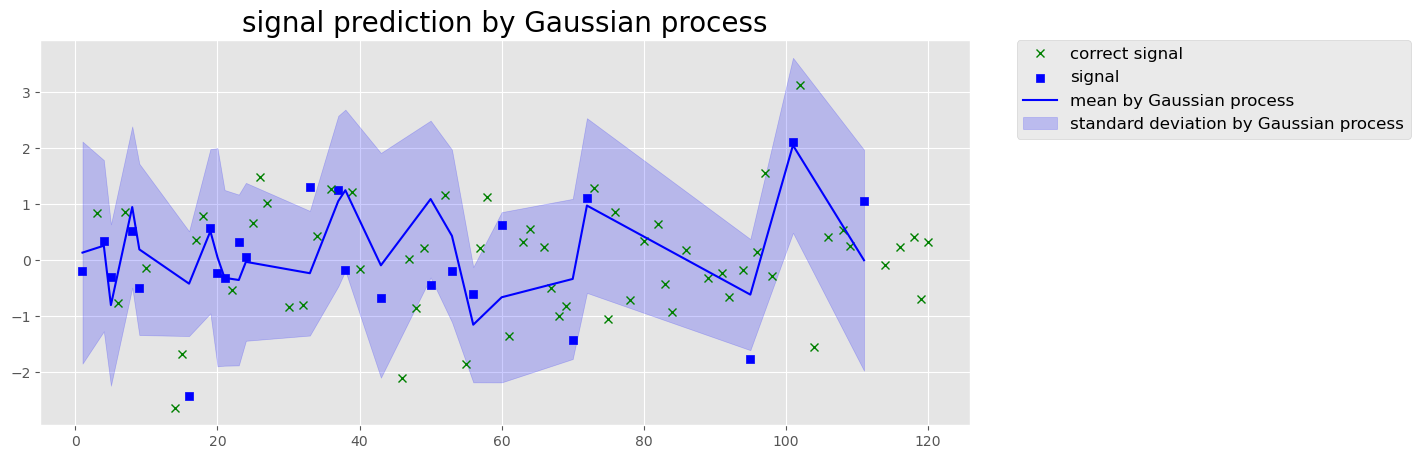

In [1119]:
# 学習済み 
Gaussian_result(X_train , y_train , X_test , y_test , mu_new , var_new )

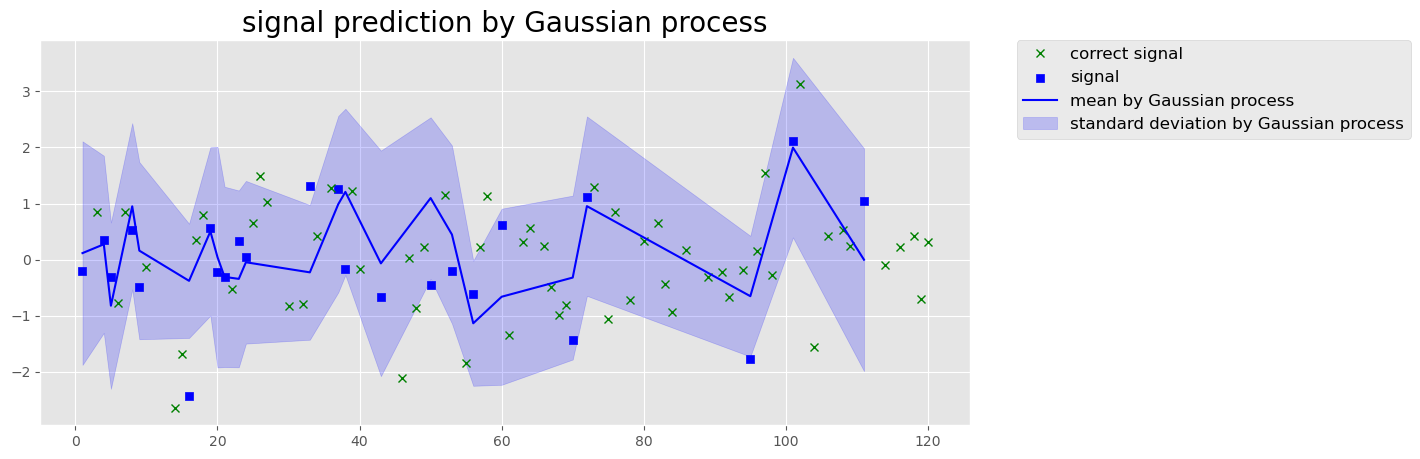

In [1120]:
# 初期 
Gaussian_result(X_train , y_train , X_test , y_test , mu , var )

以上でパラメータの学習については終わりです．

# 追加2023/5/9
# ランダムウォークの理論的な分散共分散行列を計算した上でのモデル化

## モデルの新しい構築
ガウス過程回帰がうまく行かない理由2番目である$\textbf{モデルがそもそも悪い}$について改良を施しましょう．

In [1121]:
X_train = D_train["x"]
y_train = D_train["random_walk"]
X_cross = D_cross["x"]
y_cross = D_cross["random_walk"]
X_test = D_test["x"]
y_test = D_test["random_walk"]

ここからは差分を取る前の定常分布について考えます．

計算結果から導き出されるカーネルは，以下のようになります．


$$
K^{(ideal) } = 
\frac{2}{3}
\begin{pmatrix}
1 & 1 & 1 & ・・・ & 1 \\
1 & 2 & 2 & ・・・ & 2 \\
1 & 2 & 3 & ・・・ & 3 \\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
・& ・& ・& ・・・ & ・\\
1 & 2 & 3 & ・・・ & T \\
\end{pmatrix}
$$
このことを参考に，以下のカーネルでモデル化を行うべきでした．

$$
k(x , x^{\prime}) = \theta_1 \exp{\left( - \frac{(x - x^{\prime})^2}{\theta_2} \right)} + \theta_3 \delta(x , x^{\prime}) + \theta_4 \min{\{x , x^{\prime}\}}
$$

第4項のを定義することにより，理想的なカーネルをモデル化できています．

### 学習データからカーネルを学習

In [1122]:
# パラメータ値
Theta_1 = 0.1
Theta_2 = 3.0
Theta_3 = 0.1
Theta_4 = 10.0


In [1123]:
# カーネル関数を定義
def kernel(x, x_prime, p, q, r, o):
    if x == x_prime:
        delta = 1
    else:
        delta = 0
    
    if x > x_prime:
        a = x_prime
    else:
        a = x
    kernel =  p*np.exp(-1 * (x - x_prime)**2 / q) + (r * delta) + o * a
    return kernel

In [1124]:
a = kernel(1, 1, Theta_1, Theta_2, Theta_3, Theta_4)
a

10.2

In [1125]:
b = kernel(12, 5, Theta_1, Theta_2, Theta_3, Theta_4)
b

50.000000008063495

同じ様にカーネルを計算していきましょう．

In [1126]:
# カーネル計算を実行する関数
def compute_kernel(X , Theta_1 , Theta_2 , Theta_3, Theta_4):
    inputdata_length = len(X)
    K = np.zeros((inputdata_length, inputdata_length)) # 2次元配列
    for x in range(inputdata_length):
        for x_prime in range(inputdata_length):
            K[x, x_prime] = kernel(X[x], X[x_prime], Theta_1, Theta_2, Theta_3 , Theta_4)
    return K

In [1127]:
%time  K = compute_kernel(X_train , Theta_1 , Theta_2 , Theta_3 , Theta_4)
K.shape

CPU times: user 22.9 ms, sys: 0 ns, total: 22.9 ms
Wall time: 22.7 ms


(59, 59)

同じ様にカーネルをヒートマップで可視化しましょう．

In [1128]:
K

array([[  30.2       ,   30.00497871,   30.00048279, ...,   30.        ,
          30.        ,   30.        ],
       [  30.00497871,   60.2       ,   60.07165313, ...,   60.        ,
          60.        ,   60.        ],
       [  30.00048279,   60.07165313,   70.2       , ...,   70.        ,
          70.        ,   70.        ],
       ...,
       [  30.        ,   60.        ,   70.        , ..., 1180.2       ,
        1180.07165313, 1180.02635971],
       [  30.        ,   60.        ,   70.        , ..., 1180.07165313,
        1190.2       , 1190.07165313],
       [  30.        ,   60.        ,   70.        , ..., 1180.02635971,
        1190.07165313, 1200.2       ]])

In [1129]:
# K^{-1} * y を計算する関数
def Expected_train(K , y):
    yy = np.dot(np.linalg.inv(K), y) # np.linalg.invは逆行列
    return yy

In [1130]:
np.linalg.inv(K)

array([[ 6.55974955e-02, -3.23147918e-02, -3.04231196e-04, ...,
         2.75560262e-18,  6.02889924e-18, -5.22983936e-18],
       [-3.23147918e-02,  1.29618796e-01, -9.67883171e-02, ...,
        -4.40205709e-18,  1.74687156e-18,  9.96016472e-19],
       [-3.04231196e-04, -9.67883171e-02,  1.29618502e-01, ...,
        -1.09492814e-17, -6.34821784e-18, -1.65678720e-18],
       ...,
       [ 6.57071607e-20,  1.57434076e-45,  6.57071607e-20, ...,
         1.45631748e-01, -9.64025080e-02, -5.91837489e-04],
       [ 1.07372829e-17,  3.10293388e-45,  1.07372829e-17, ...,
        -9.64025080e-02,  1.93430472e-01, -9.67128469e-02],
       [-1.08251764e-17, -3.11178335e-45, -1.08251764e-17, ...,
        -5.91837489e-04, -9.67128469e-02,  9.75045210e-02]])

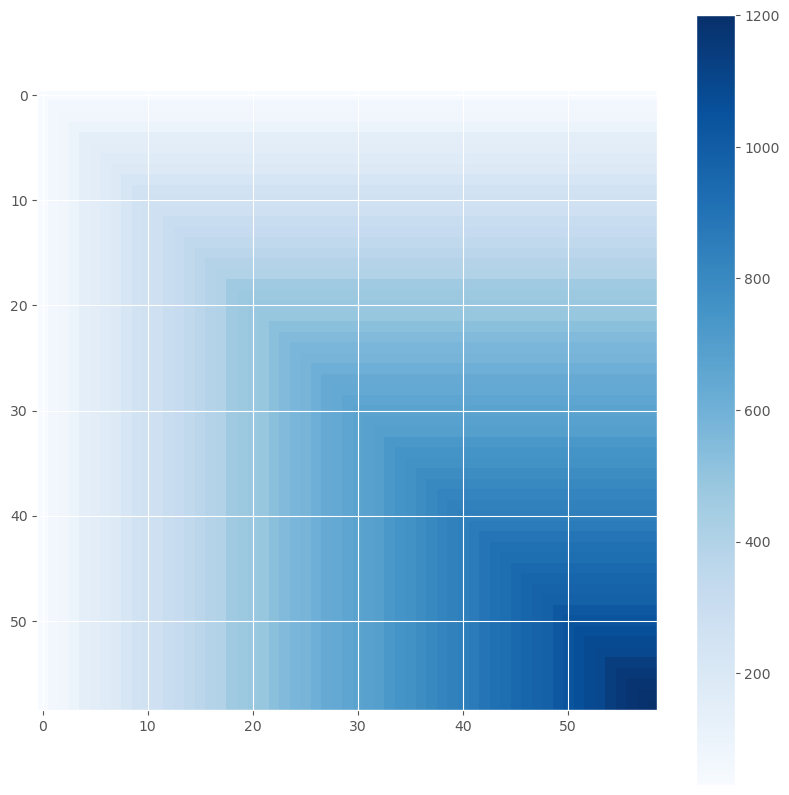

In [1131]:
fig, axes = plt.subplots(figsize=(10, 10))
im = axes.imshow(K, cmap='Blues')
fig.colorbar(im, ax=axes)
plt.show()

### テストデータへの当てはめ

同じ様にテストデータに当てはめて予測分布をしっかりと再現しているか確認しましょう．

予測したいテストデータ$X^{*} = (x^{*}_1 , ... ,x^{*}_{N_{test}})$と予測したい出力 $\vec{y}^{*} = (y^{*}_1 , ... ,y^{*}_{N_{test}})$とする．

教科書P84の公式3.8より$\vec{y}^{*}$の予測分布は
$$
p(y^{*} | X^{*} ,\mathcal{D}) = \mathcal{N} (\textbf{k}^{\top}_* K^{-1} \vec{y} , \textbf{k}_{**} - \textbf{k}^{\top}_* K^{-1} \textbf{k}_*)
$$

期待値と分散をそれぞれ計算することで，上の予測分布を計算することができます．

最終的なプロットに必要なのは分散のみで共分散は不要です．

In [1132]:
def predict(X_train , y_train , X_test , Theta_1 , Theta_2 , Theta_3 , Theta_4 , K) :
    # 平均
    mu = []
    # 分散
    var = []

    # K^{-1} * y を計算する関数
    yy = Expected_train(K , y_train)

    train_length = len(X_train)
    test_length = len(X_test)
    for x_test in range(test_length):

    # テストデータとトレーニングデータ間のカーネル行列の下地を準備
        k = np.zeros(train_length)
        for x in range(train_length):
            
            # 訓練データとテストデータのカーネル
            k[x] = kernel(X_train[x], X_test[x_test], Theta_1, Theta_2, Theta_3 , Theta_4) # (3.68)式
            
            #テストデータ同士のカーネル
        s = kernel(X_test[x_test], X_test[x_test], Theta_1, Theta_2, Theta_3 , Theta_4 ) # (3.69)式

    # 内積はドットで計算して, 平均値の配列に追加
        mu.append(np.dot(k, yy)) # (3.74)式の期待値
    
    # 先に『k * K^-1』の部分を(内積なのでドットで)計算
        kK_ = np.dot(k, np.linalg.inv(K)) 
    
    # 後半部分との内積をドットで計算して, 分散の配列に追加
        var.append(s - np.dot(kK_, k.T)) # (3.74)式の分散
    
    return mu , var

In [1133]:
mu , var = predict(X_train , y_train , X_test , Theta_1 , Theta_2 , Theta_3 , Theta_4 , K)

In [1134]:
# ガウス過程回帰の結果をプロットする関数
def Gaussian_result(X_train , y_train , X_test , y_test , mu , var ):
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    plt.figure(figsize=(12, 5))
    plt.title('signal prediction by Gaussian process', fontsize=20)
    
    # 元の信号
    plt.plot(X_train ,y_train, 'x', color='green', label='correct signal')
    # 正解のプロット
    plt.scatter(X_test, y_test , marker='s' , color='blue', label='signal')
    # ガウス過程で求めた平均値を信号化
    plt.plot(X_test, mu, color='blue', label='mean by Gaussian process')
    
    # ガウス過程で求めた標準偏差を範囲化 alphaは透明度
    plt.fill_between(X_test, mu + 2 * std, mu - 2 * std, alpha=0.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

    # 平均値±(標準偏差×2) … 95%の確率で範囲内に指定の数値が現れる

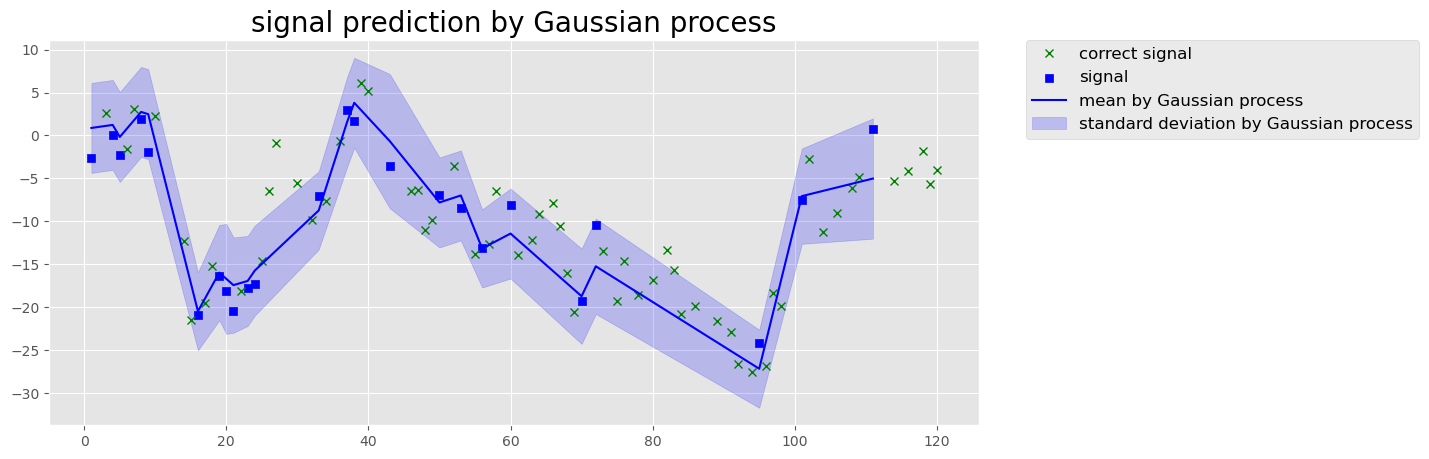

In [1135]:
Gaussian_result(X_train , y_train , X_test , y_test , mu , var )

うまく行っていますね！

ここからさらに良くした場合は，パラメータを最尤法によって更新したり，カーネルのモデル化を更に洗礼させるとよいです．

$\textbf{が！．またパラメータ勾配という厄介な計算をしなくてはいけません！}$

$\textbf{それならば，データの前処理をして教科書に乗っているカーネルを用いたほうが遥かに楽です．}$

また，再度の注意になりますが，生データでは理論的なカーネルは計算できません．

その場合は，時系列解析の基礎的な知識（定常分布になるようにデータを前処理する，スペクトルを見て自己共分散を測定する）を駆使する必要があります．

それらのことを除いて，ガウス過程回帰の基本的な内容は実装できました．お疲れ様でした．